a = 1
T = 1
l = 1
N = 10
K = 250
h = 0.1
tau = 0.004000000000000001
sigma = 0.4


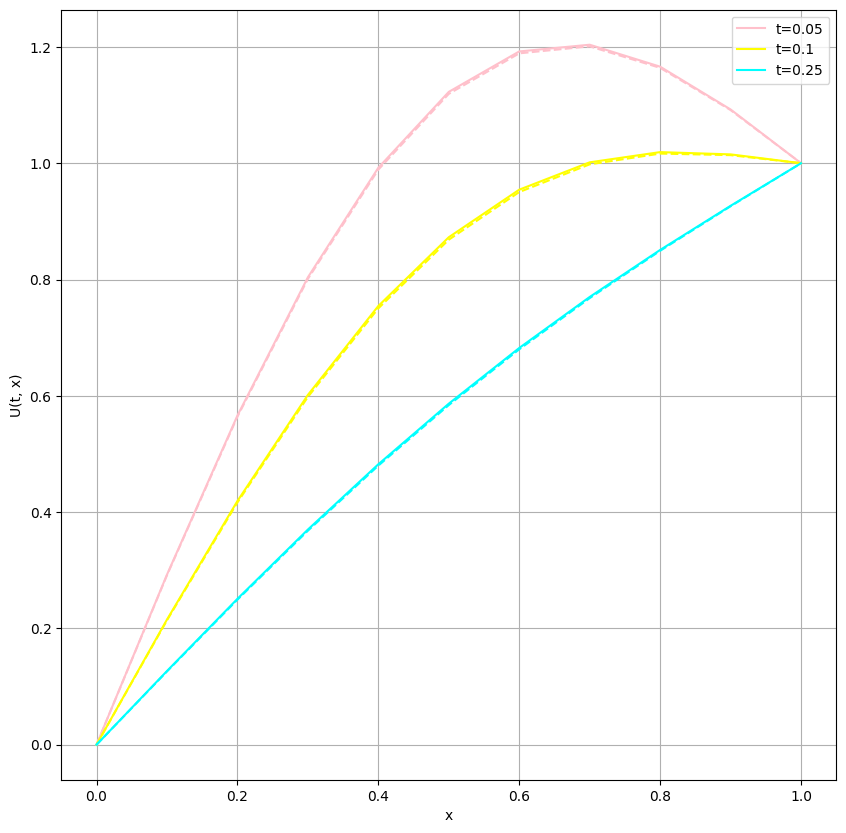

/tmp/ipython-input-478367878.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


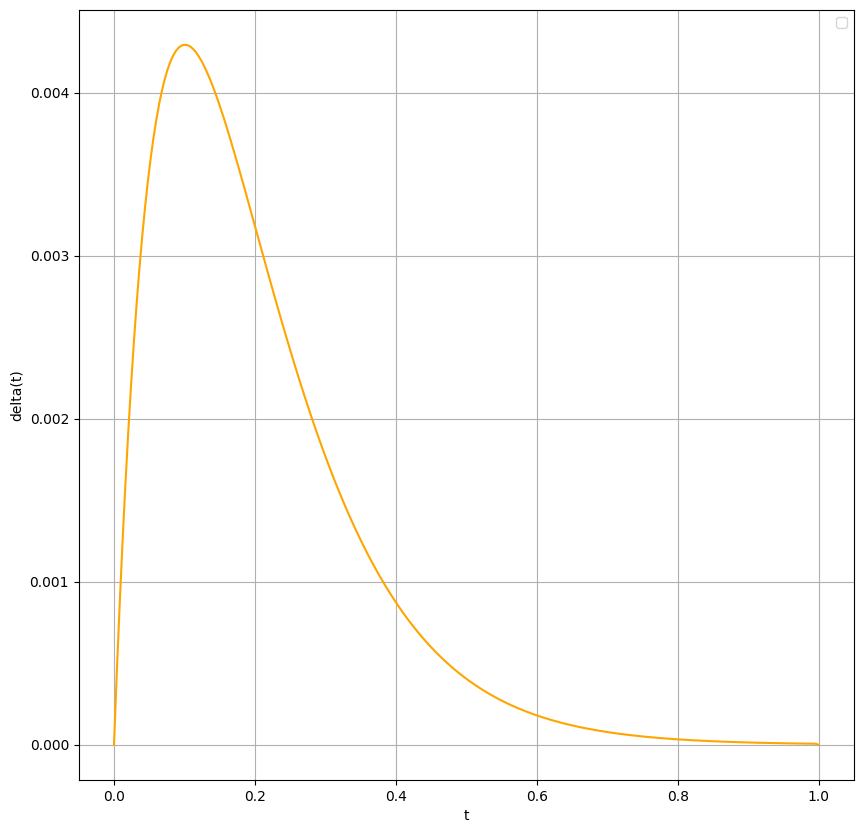

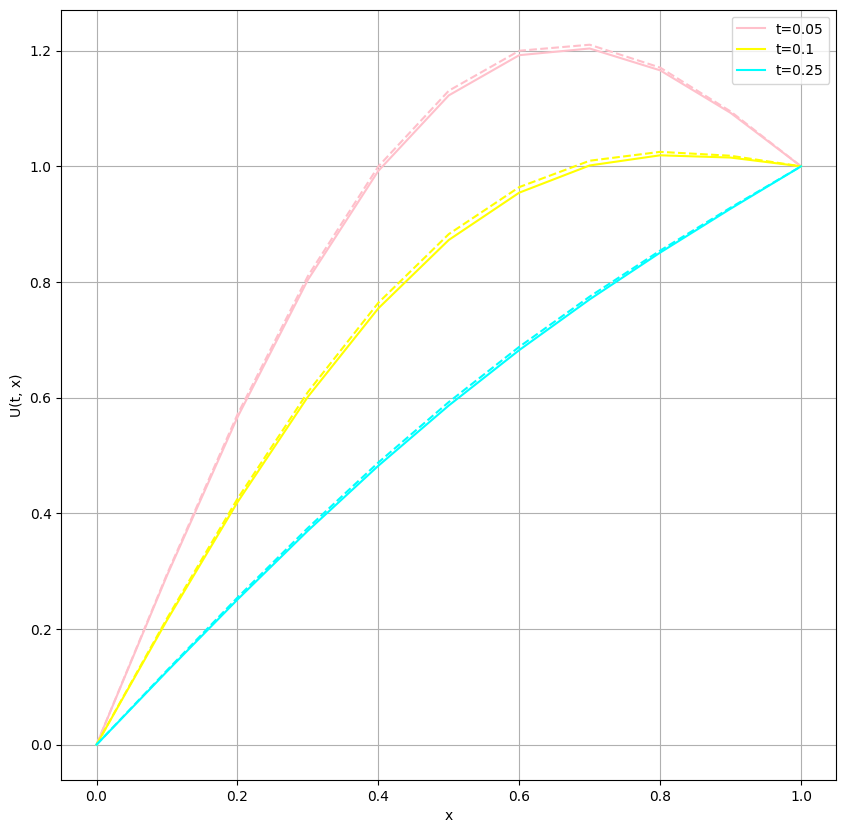

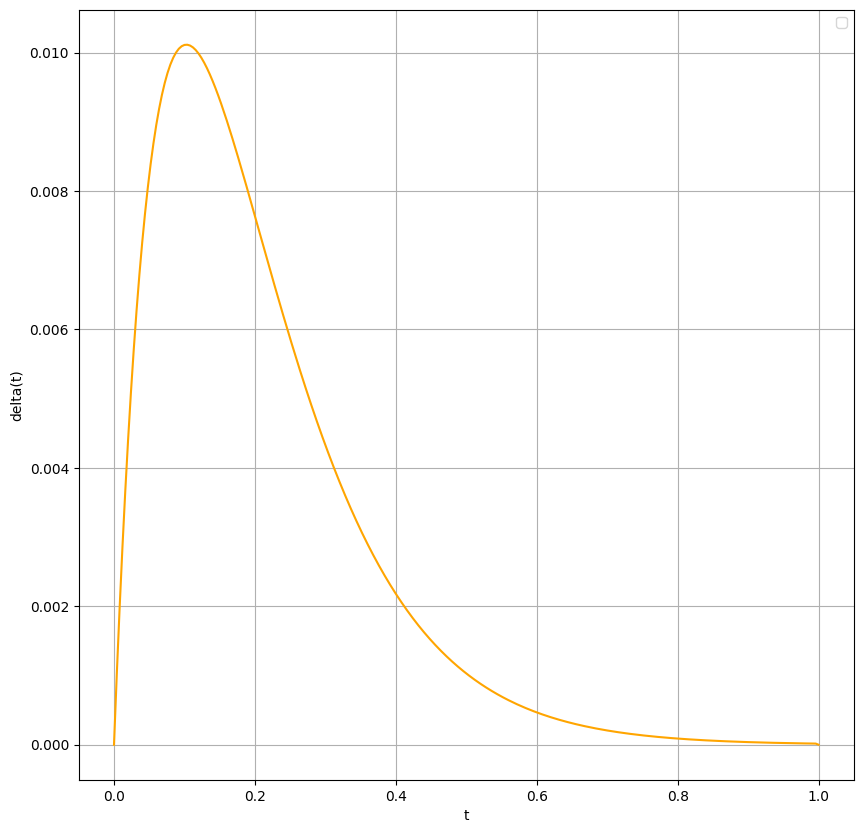

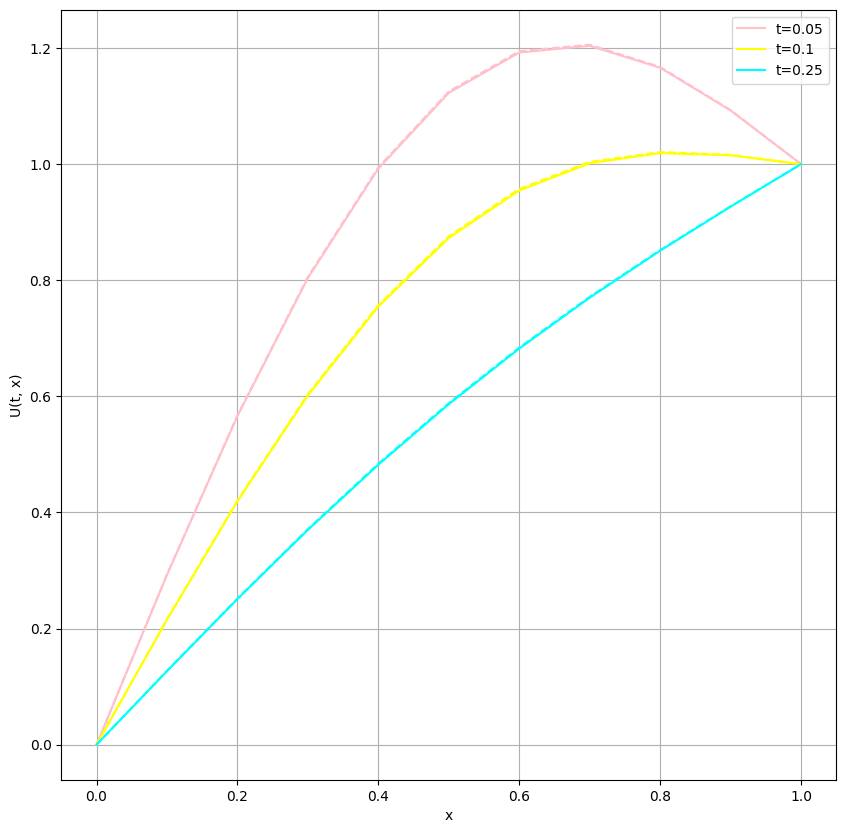

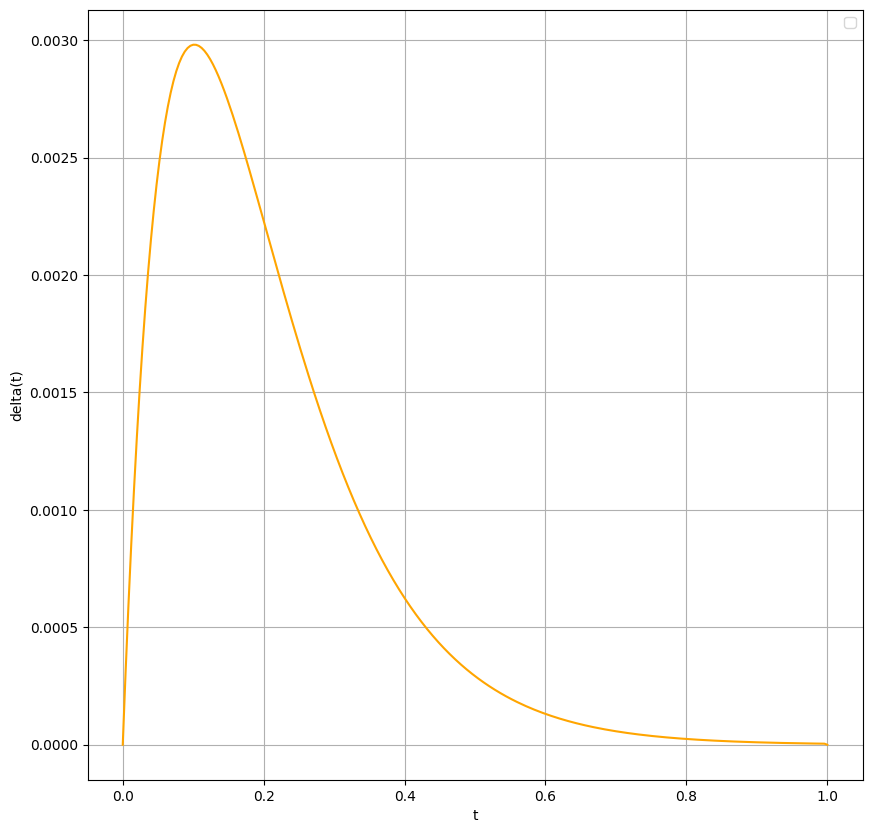

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 10]

# Задаем начальные краевые условия:
def u_0_t(t):
  return 0

def u_l_t(t):
  return 1

def u_x_0(x):
  return x + np.sin(np.pi * x)

# Аналитическое решение:
def solution(x, t, a):
  return x + np.exp(-(np.pi * np.pi) * a * t) * np.sin(np.pi * x)

# Определяем ошибки:
def error(h, tau, K, l, T, a, mesh, solution):
  x_array = np.arange(0, l + h, h)
  errors = np.zeros(K + 1)

  for t in range(0, K):
    u_correct = solution(x_array, t * tau, a)
    u_calculated = mesh[t]
    errors[t] = np.amax(np.abs(u_correct - u_calculated))
  return errors

# График решений:
def graph_solution(h, tau, K, l, T, a, mesh, solution):
  x_array = np.arange(0, l + h, h)
  fig, ax = plt.subplots()
  t = [int(K * 0.05), int(K * 0.1), int(K * 0.25)]
  colors = ['pink', 'yellow', 'aqua']

  for i in range(len(t)):
    u_correct = solution(x_array, t[i] * tau, a)
    u_calculated = mesh[t[i]]
    ax.plot(x_array, u_correct, color=colors[i], label='t=%s' % round(t[i] * tau, 2))
    ax.plot(x_array, u_calculated, color=colors[i], linestyle='--')

  ax.set_xlabel('x')
  ax.set_ylabel('U(t, x)')
  ax.grid()
  ax.legend()
  plt.show()

# График ошибок:
def graph_errors(T, tau, errors):
  t_array = np.arange(0, T + tau, tau)
  fig, ax = plt.subplots()
  ax.plot(t_array, errors, color='orange')
  ax.set_xlabel('t')
  ax.set_ylabel('delta(t)')
  ax.grid()
  ax.legend()
  plt.show()

# Метод прогонки:
def sweep_mehod(A, b):
  p = np.zeros(len(b))
  q = np.zeros(len(b))

# Прямой ход: поиск прогоночных коэффициентов P и Q
  p[0] = -A[0][1] / A[0][0]
  q[0] = b[0] / A[0][0]
  for i in range(1, len(p) - 1):
    p[i] = -A[i][i + 1] / (A[i][i] + A[i][i - 1] * p[i - 1])
    q[i] = (b[i] - A[i][i - 1] * q[i - 1]) / (A[i][i] + A[i][i - 1] * p[i- 1])
  p[-1] = 0
  q[-1] = (b[-1] - A[-1][-2] * q[-2]) / (A[-1][-1] + A[-1][-2] * p[-2])

# Обратный ход: поиск x
  x = np.zeros(len(b))
  x[-1] = q[-1]

  for i in reversed(range(len(b) - 1)):
    x[i] = p[i] * x[i + 1] + q[i]
  return x

# Явная схема:
def explicit(a, T, l, N, K, h, tau, sigma):
# Проверка на устойчивость:
  if (sigma > 0.5):
    raise Exception("Измените параметры сетки")
  mesh = np.zeros((K + 1, N + 1))
# Начальное условие. Заполнение нижнего слоя:
  for j in range(N + 1):
    mesh[0][j] = u_x_0(j * h)
# Граничные условия. Заполнение первого и последнего столбца:
  for i in range(1, K):
    mesh[i][0] = u_0_t(i * tau)
    mesh[i][N] = u_l_t(i * tau)
# Заполнение верхних слоев. Явная конечно-разностная схема:
  for i in range(1, K):
    for j in range(1, N):
      mesh[i][j] = sigma * mesh[i - 1][j + 1] + (1 - 2 * sigma) * mesh[i - 1][j] + sigma * mesh[i - 1][j - 1]
  return mesh

# Неявная схема:
def implicit(a, T, l, N, K, h, tau, sigma):
  a_j = sigma
  b_j = -(1 + 2 * sigma)
  c_j = sigma
  mesh = np.zeros((K + 1, N + 1))
# Начальное условие. Заполнение нижнего слоя:
  for j in range(N + 1):
    mesh[0][j] = u_x_0(j * h)
# Граничные условия. Заполнение первого и последнего столбца:
  for i in range(1, K):
    mesh[i][0] = u_0_t(i * tau)
    mesh[i][N] = u_l_t(i * tau)

# Заполнение верхних слоев. Явная конечно-разностная схема:
  for i in range(1, K + 1):
    matrix = np.zeros((N - 1, N - 1))
    d = np.zeros(N - 1)
    matrix[0][0] = b_j
    matrix[0][1] = c_j
    d[0] = -(mesh[i - 1][1] + sigma * u_0_t(i * tau))

    for j in range(1, N - 2):
      matrix[j][j - 1] = a_j
      matrix[j][j] = b_j
      matrix[j][j + 1] = c_j
      d[j] = -mesh[i - 1][j + 1]

    matrix[N - 2][N - 3] = a_j
    matrix[N - 2][N - 2] = b_j
    d[N - 2] = -(mesh[i - 1][N - 1] + sigma * u_l_t(i * tau))

# СЛАУ методом прогонки:
    solve = sweep_mehod(matrix, d)
    mesh[i][1:N] = solve
  return mesh


# Схема Кранка-Николсона:
def CrankNicholson(teta, a, T, l, N, K, h, tau, sigma):

  if teta < 0 or teta > 1:
    raise Exception("Teta должна быть от 0 до 1")

  elif teta == 0:
    return explicit(a, T, l, N, K, h, tau)

  elif teta == 1:
    return implicit(a, T, l, N, K, h, tau)

  a_j = sigma * teta
  b_j = -(1 + 2 * sigma * teta)
  c_j = sigma * teta
  mesh = np.zeros((K + 1, N + 1))

# Начальное условие. Заполнение нижнего слоя:
  for j in range(N + 1):
    mesh[0][j] = u_x_0(j * h)
# Граничные условия. Заполнение первого и последнего столбца:
  for i in range(1, K):
    mesh[i][0] = u_0_t(i * tau)
    mesh[i][N] = u_l_t(i * tau)
# Заполнение верхних слоев. Явная конечно-разностная схема:
  for i in range(1, K + 1):
    matrix = np.zeros((N - 1, N - 1))
    d = np.zeros(N - 1)

    matrix[0][0] = b_j
    matrix[0][1] = c_j
    d[0] = -(mesh[i - 1][1] + sigma * (1 - teta) * (mesh[i - 1][2] - 2 * mesh[i - 1][1] + mesh[i - 1][0]) + sigma * teta * u_0_t(i * tau))

    for j in range(1, N - 2):
      matrix[j][j - 1] = a_j
      matrix[j][j] = b_j
      matrix[j][j + 1] = c_j
      d[j] = -(mesh[i - 1][j + 1] + sigma * (1 - teta) * (mesh[i - 1][j + 2] - 2 * mesh[i - 1][j + 1] + mesh[i- 1][j]))

    matrix[N - 2][N - 3] = a_j
    matrix[N - 2][N - 2] = b_j
    d[N - 2] = -(mesh[i - 1][N - 1] + sigma * (1 - teta) * (mesh[i - 1][N] - 2 * mesh[i - 1][N - 1] + mesh[i - 1][N -2]) + sigma * teta * u_l_t(i * tau))

    solve = sweep_mehod(matrix, d)
    mesh[i][1:N] = solve
  return mesh


def main():
  a = 1
  T = 1
  l = 1
  N = 10
  sigma = 0.4
  h = l / N
  tau = sigma * h ** 2 / a
  K = int(round(T / tau))

  print("a =", a)
  print("T =", T)
  print("l =", l)
  print("N =", N)
  print("K =", K)
  print("h =", h)
  print("tau =", tau)
  print("sigma =", sigma)

  mesh1 = explicit(a, T, l, N, K, h, tau, sigma)
  graph_solution(h, tau, K, l, T, a, mesh1, solution)

  errors1 = error(h, tau, K, l, T, a, mesh1, solution)
  graph_errors(T, tau, errors1)

  mesh2 = implicit(a, T, l, N, K, h, tau, sigma)
  graph_solution(h, tau, K, l, T, a, mesh2, solution)

  errors2 = error(h, tau, K, l, T, a, mesh2, solution)
  graph_errors(T, tau, errors2)

  mesh3 = CrankNicholson(0.5, a, T, l, N, K, h, tau, sigma)
  graph_solution(h, tau, K, l, T, a, mesh3, solution)

  errors3 = error(h, tau, K, l, T, a, mesh3, solution)
  graph_errors(T, tau, errors3)


main()
